In [9]:
import importlib
import sys
import os
import UAVenv
from UAVenv import UAVEnv
importlib.reload(UAVenv)
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]]

 [[1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]]]
5
8


In [10]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [11]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32 * state_dim * state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # 添加通道维度 (batch, 1, 5, 5) en: add channel dimension (batch, 1, 5, 5)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)
    
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32 * state_dim * state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # 添加通道维度 (batch, 1, 5, 5) en: add channel dimension (batch, 1, 5, 5)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [12]:
class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数 en: number of epochs to train on a single sequence
        self.eps = eps  # PPO中截断范围的参数 en: parameter for clipping range in PPO
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断 en: clipping
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数 en: PPO loss function
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [13]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    return_list_2=[]
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = [{'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []} for _ in range(env.N)]
                state = env.reset()
                done = False
                while not done:
                    actions = [agent.take_action(state[n]) for n in range(env.N)]
                    next_state, reward, done = env.step(actions)
                    for n, uav in enumerate(env.uavs):
                        if uav['done'] == False:
                            transition_dict[n]['states'].append(state[n])
                            transition_dict[n]['actions'].append(actions[n])
                            transition_dict[n]['next_states'].append(next_state[n])
                            transition_dict[n]['rewards'].append(reward[n])
                            transition_dict[n]['dones'].append(done)
                    state = next_state
                    episode_return += sum(reward)
                return_list.append(episode_return)
                return_list_2.append(sum(sum(env.uncertainty_matrix))/100)
                for n in range(env.N):
                    agent.update(transition_dict[n])
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:]),'uncertainty_matrix': '%.3f' % np.mean(return_list_2[-10:])})
                pbar.update(1)
    return return_list , return_list_2

In [14]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env = UAVEnv()
state_dim = env.state_dim
action_dim = env.action_dim
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list,return_list_2 = train_on_policy_agent(env, agent, num_episodes)

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 100/100 [00:24<00:00,  4.00it/s, episode=1000, return=1.150, uncertainty_matrix=0.580]


In [15]:
import pickle

# 保存
with open("mppo_returns.pkl", "wb") as f:
    pickle.dump((return_list, return_list_2), f)

# 读取
with open("mppo_returns.pkl", "rb") as f:
    return_list, return_list_2 = pickle.load(f)

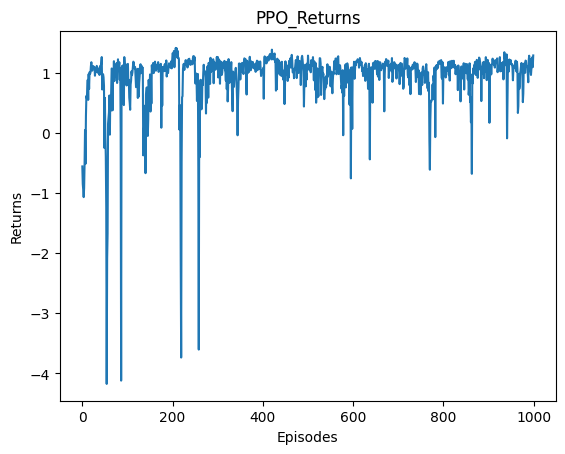

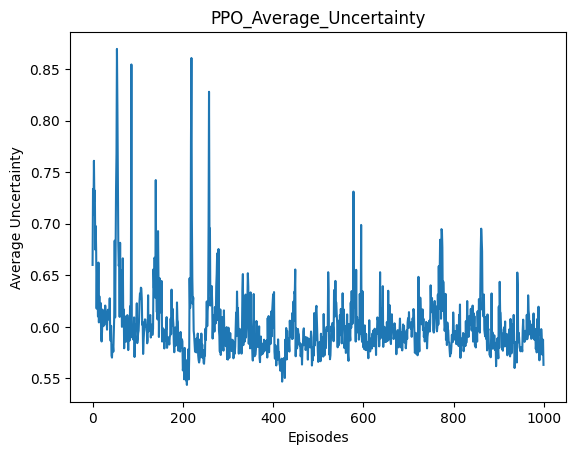

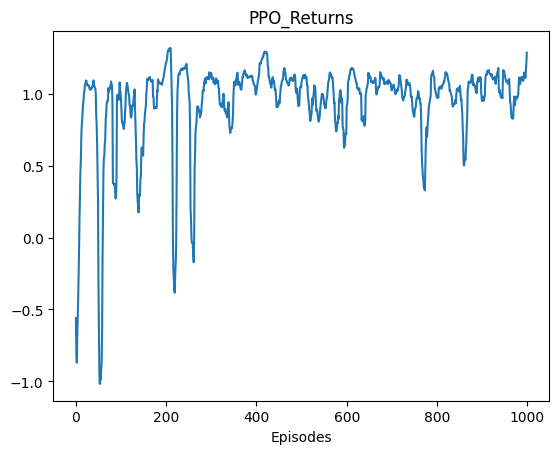

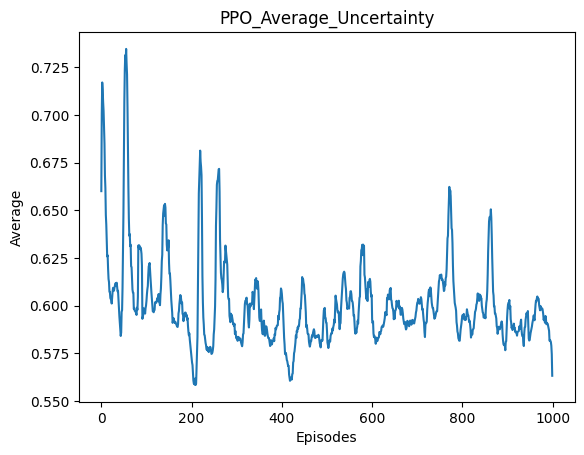

In [16]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO_Returns')
plt.show()
episodes_list = list(range(len(return_list_2)))
plt.plot(episodes_list, return_list_2)
plt.xlabel('Episodes')
plt.ylabel('Average Uncertainty')
plt.title('PPO_Average_Uncertainty')
plt.show()

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.title('PPO_Returns')
plt.show()
mv_return = moving_average(return_list_2, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Average')
plt.title('PPO_Average_Uncertainty')
plt.show()